## Установка необходимых библиотек в виртуальное окружение

In [1]:
#! pip install -r requirements.txt -q

# Загрузка библотек

In [2]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Загрузка данных

In [3]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [4]:
df_train.set_index("id", inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

In [5]:
df_train = df_train.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())
df_train.columns

Index(['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors', 'flood_probability'],
      dtype='object')

In [6]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [7]:
df_test.set_index("id", inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745305 entries, 1117957 to 1863261
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   MonsoonIntensity                 745305 non-null  int64
 1   TopographyDrainage               745305 non-null  int64
 2   RiverManagement                  745305 non-null  int64
 3   Deforestation                    745305 non-null  int64
 4   Urbanization                     745305 non-null  int64
 5   ClimateChange                    745305 non-null  int64
 6   DamsQuality                      745305 non-null  int64
 7   Siltation                        745305 non-null  int64
 8   AgriculturalPractices            745305 non-null  int64
 9   Encroachments                    745305 non-null  int64
 10  IneffectiveDisasterPreparedness  745305 non-null  int64
 11  DrainageSystems                  745305 non-null  int64
 12  CoastalVulnerability        

In [8]:
df_test = df_test.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())
df_test.columns

Index(['monsoon_intensity', 'topography_drainage', 'river_management',
       'deforestation', 'urbanization', 'climate_change', 'dams_quality',
       'siltation', 'agricultural_practices', 'encroachments',
       'ineffective_disaster_preparedness', 'drainage_systems',
       'coastal_vulnerability', 'landslides', 'watersheds',
       'deteriorating_infrastructure', 'population_score', 'wetland_loss',
       'inadequate_planning', 'political_factors'],
      dtype='object')

## Предобработка данных

In [9]:
df_train.isna().sum()

monsoon_intensity                    0
topography_drainage                  0
river_management                     0
deforestation                        0
urbanization                         0
climate_change                       0
dams_quality                         0
siltation                            0
agricultural_practices               0
encroachments                        0
ineffective_disaster_preparedness    0
drainage_systems                     0
coastal_vulnerability                0
landslides                           0
watersheds                           0
deteriorating_infrastructure         0
population_score                     0
wetland_loss                         0
inadequate_planning                  0
political_factors                    0
flood_probability                    0
dtype: int64

In [10]:
df_train.duplicated().sum()

np.int64(0)

In [11]:
df_test.duplicated().sum()

np.int64(0)

In [12]:
df_test.isna().sum()

monsoon_intensity                    0
topography_drainage                  0
river_management                     0
deforestation                        0
urbanization                         0
climate_change                       0
dams_quality                         0
siltation                            0
agricultural_practices               0
encroachments                        0
ineffective_disaster_preparedness    0
drainage_systems                     0
coastal_vulnerability                0
landslides                           0
watersheds                           0
deteriorating_infrastructure         0
population_score                     0
wetland_loss                         0
inadequate_planning                  0
political_factors                    0
dtype: int64

## Исследовательский анализ данных

In [13]:
def histogram_boxplot(data):
    """Функция для построения гистограмм и графиков размаха количественных столбцов."""

    num_columns = data.select_dtypes(include='number').columns

    plt.figure(figsize=(10, 5 * len(num_columns)))
    for i, col in enumerate(num_columns):
        plt.subplot(len(num_columns), 2, 2*i+1)
        sns.histplot(data=data, x=col, kde=True)
        plt.title(f'Гистограмма {col}')
        plt.ylabel('Количество')

        plt.subplot(len(num_columns), 2, 2*i+2)
        sns.boxplot(data=data, x=col)
        plt.title(f'Диаграмма размаха {col}')

    plt.tight_layout()
    plt.show()

In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
monsoon_intensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
topography_drainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
river_management,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
climate_change,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
dams_quality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
agricultural_practices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


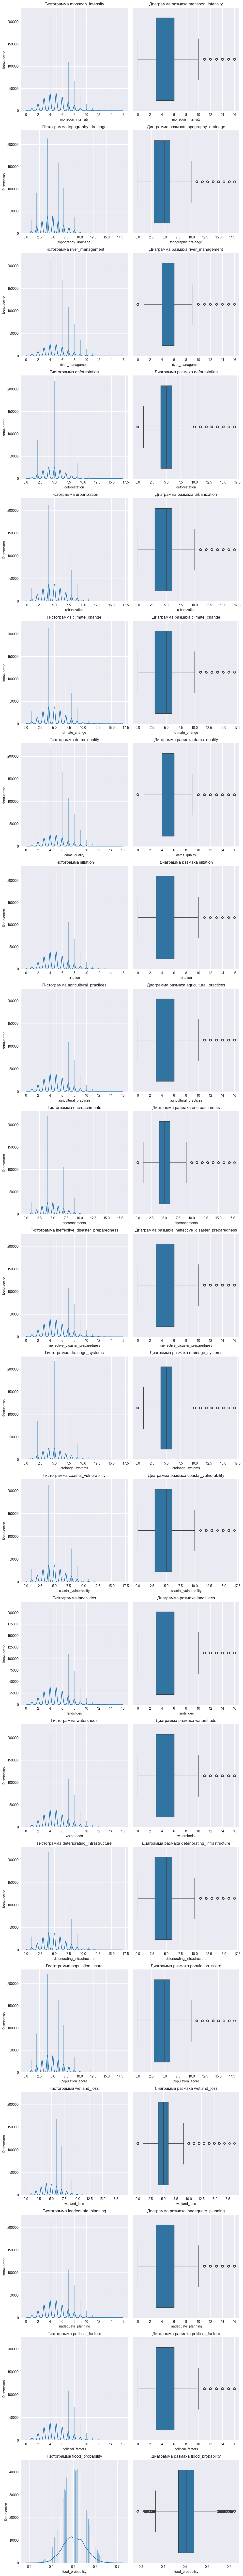

In [15]:
histogram_boxplot(df_train)

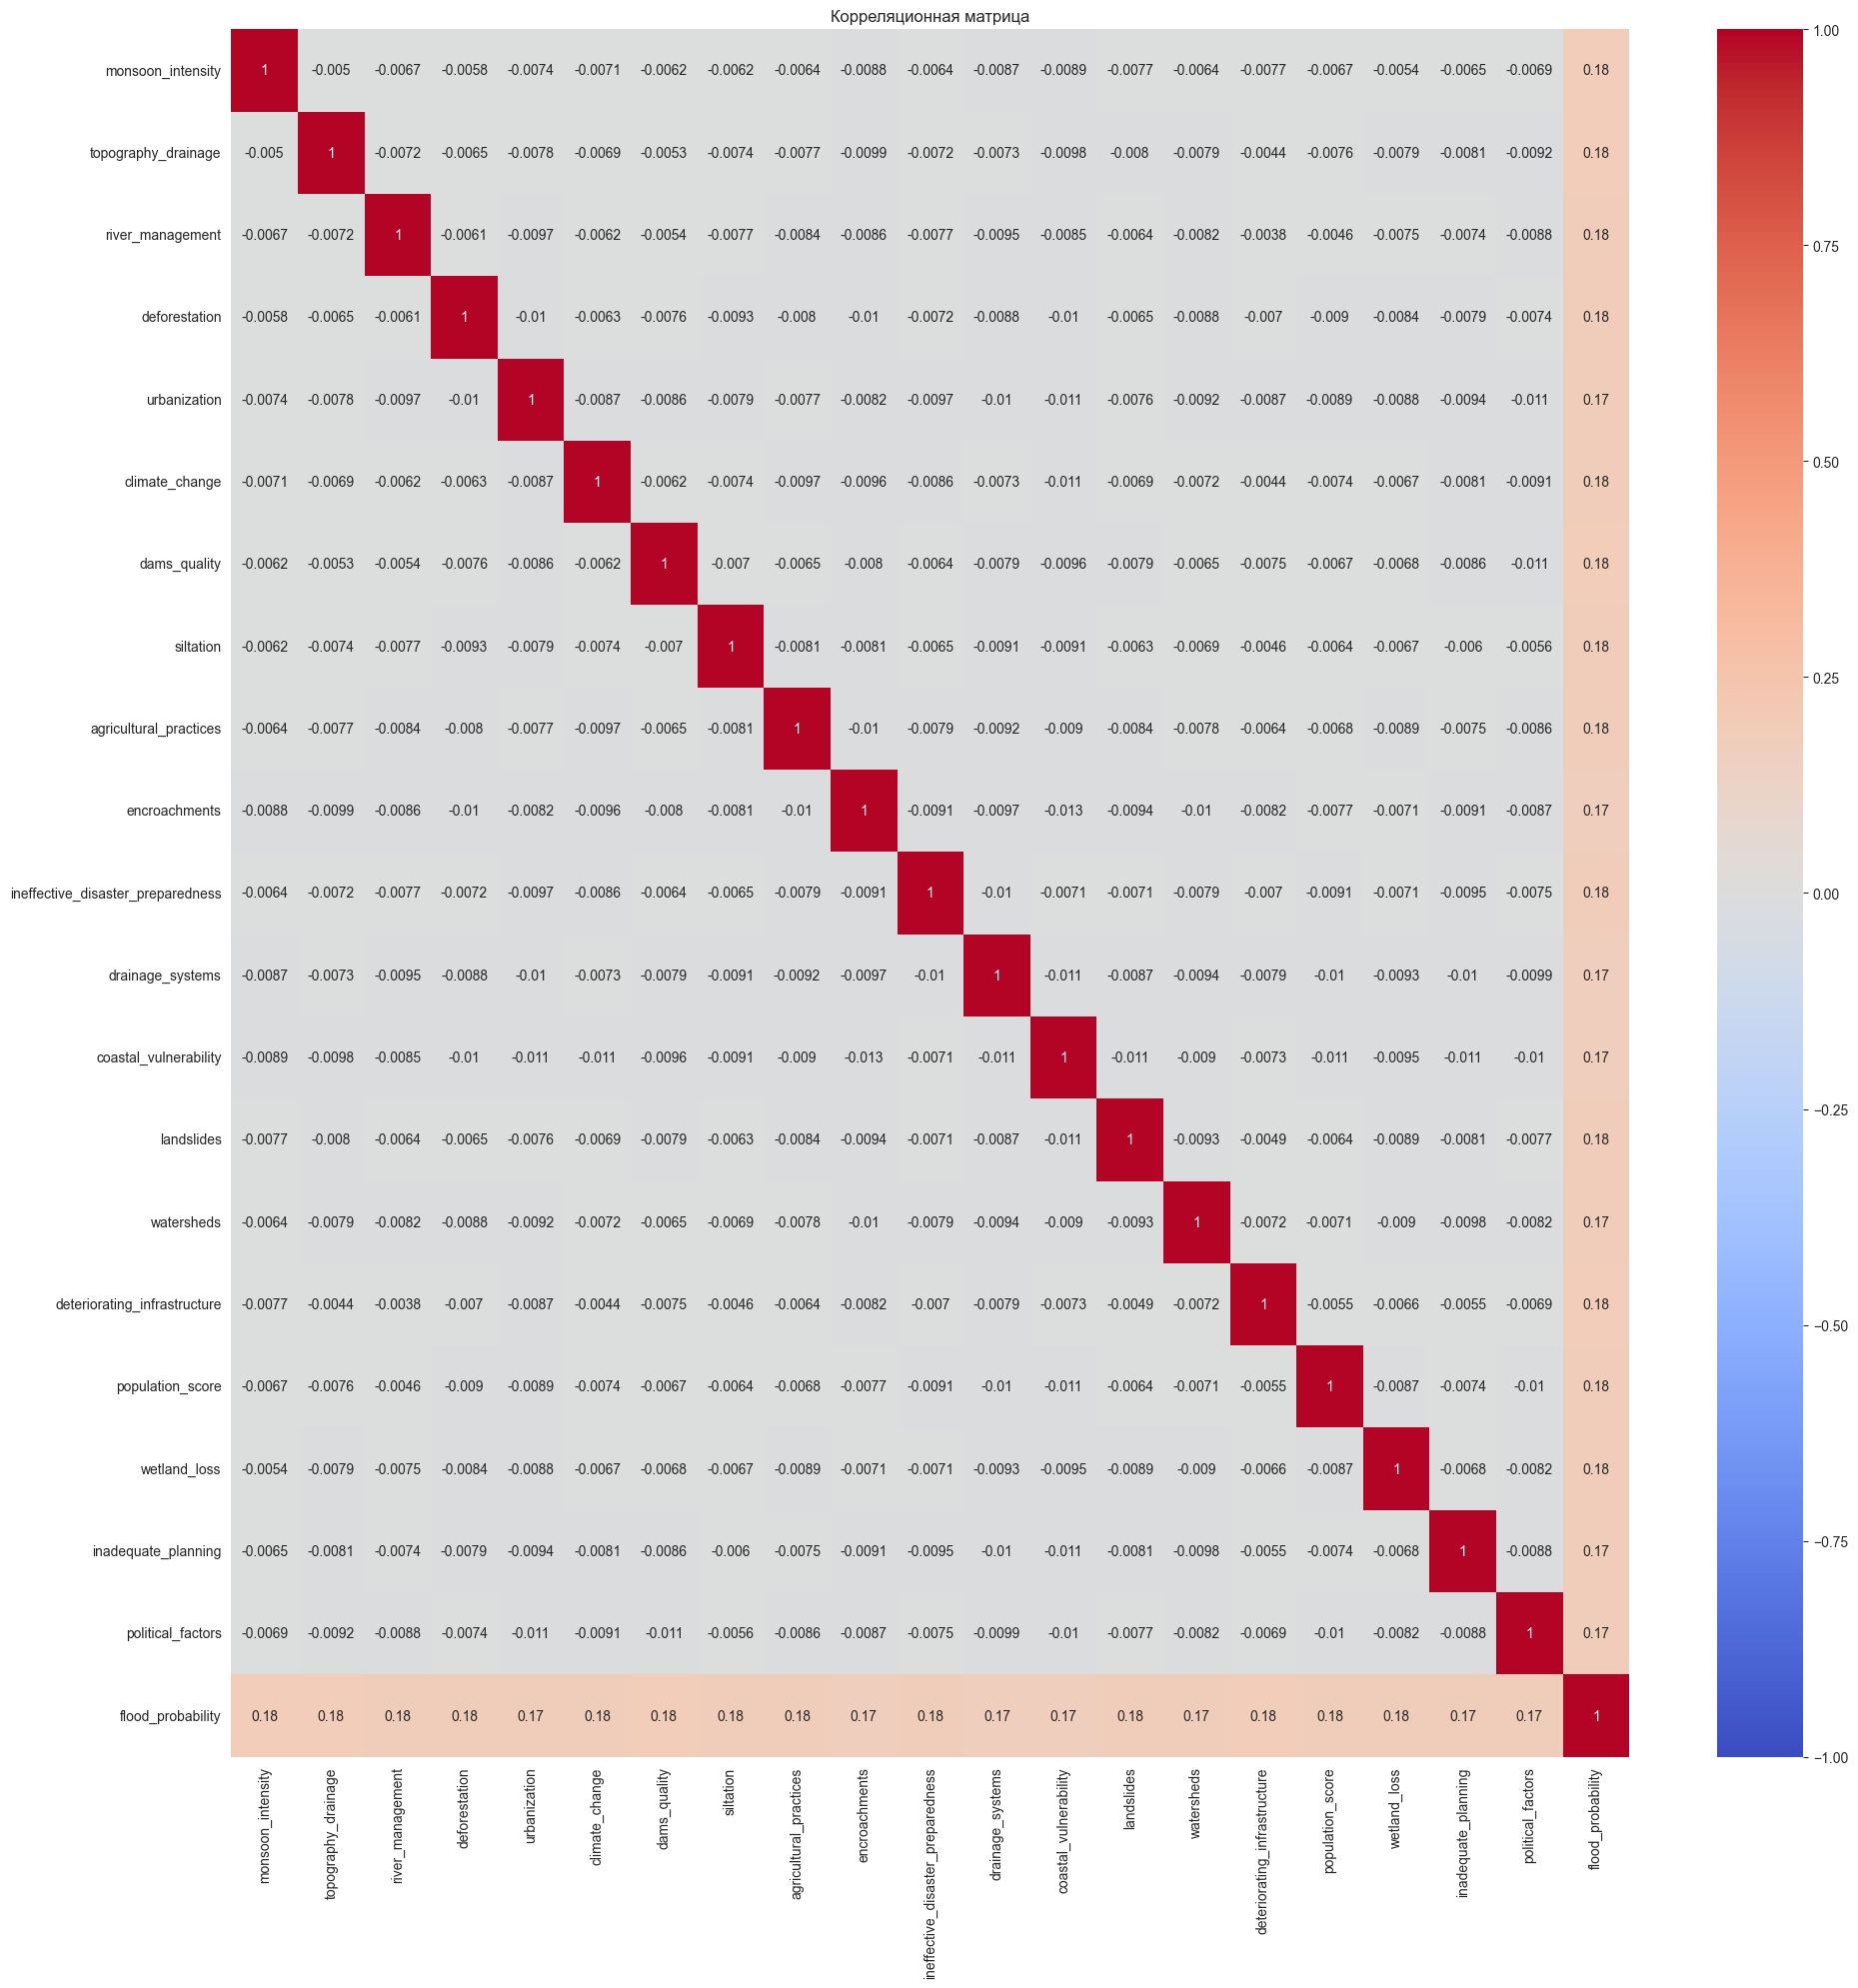

In [16]:
correlation_matrix= df_train.corr(method="spearman")
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

interval columns not set, guessing: ['monsoon_intensity', 'topography_drainage', 'river_management', 'deforestation', 'urbanization', 'climate_change', 'dams_quality', 'siltation', 'agricultural_practices', 'encroachments', 'ineffective_disaster_preparedness', 'drainage_systems', 'coastal_vulnerability', 'landslides', 'watersheds', 'deteriorating_infrastructure', 'population_score', 'wetland_loss', 'inadequate_planning', 'political_factors', 'flood_probability']


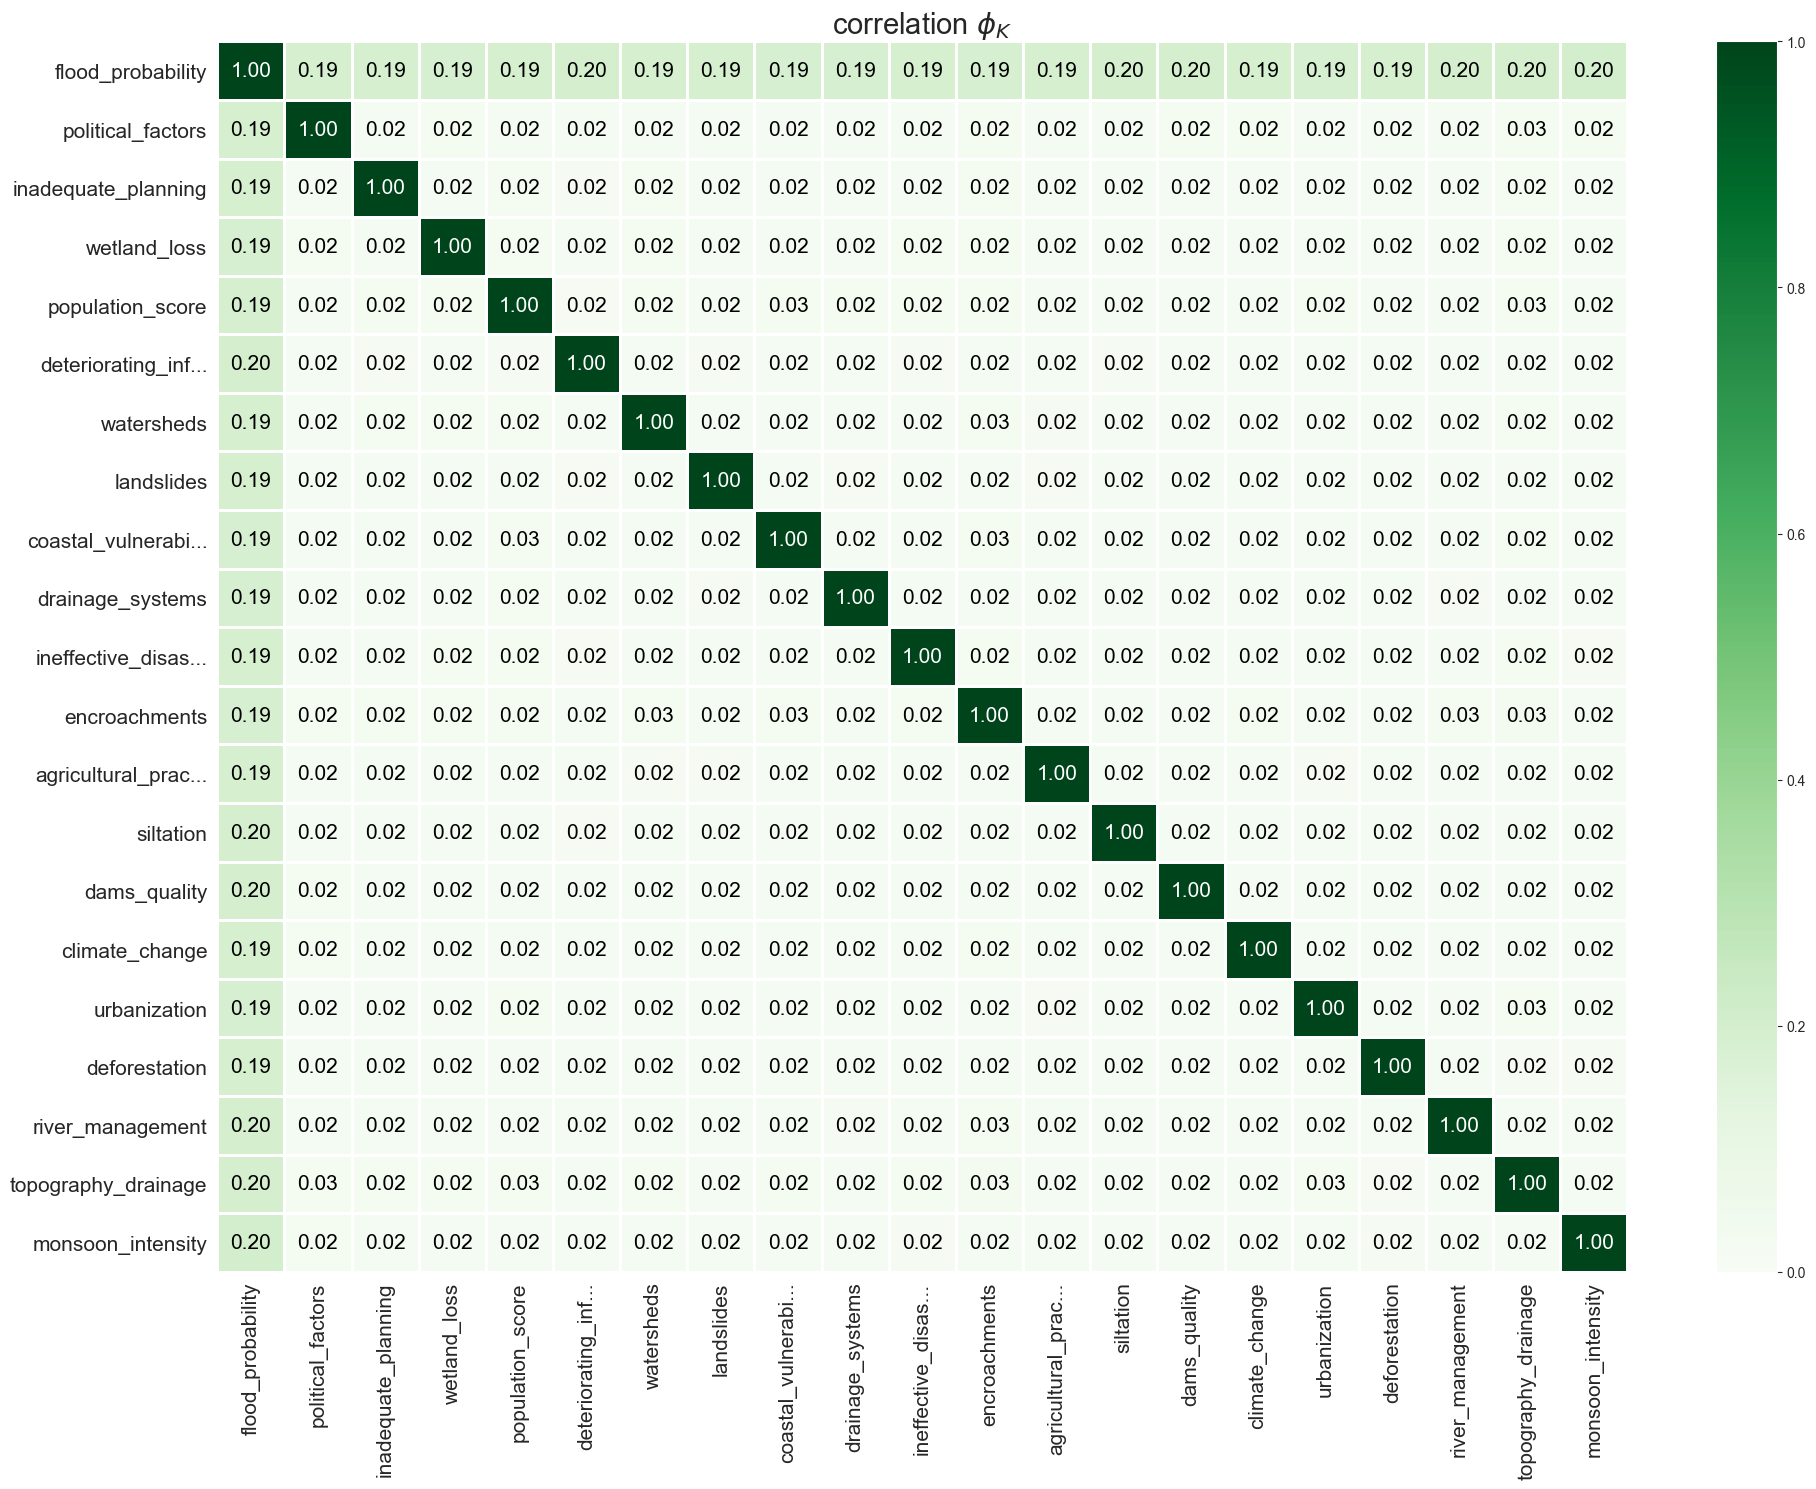

In [17]:
phik_overview = phik.phik_matrix(df_train)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

## Обучение модели и подчсет метрик

In [18]:
def rmse_scorer(y_true, y_pred):
    """Функция вычисления RMSE."""
    mse = mean_squared_error(y_true, y_pred)
    result = np.sqrt(mse)
    return result

In [19]:
x = df_train.drop(columns=["flood_probability"], axis=1)
y = df_train["flood_probability"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    shuffle=True,
    random_state=42
)

In [21]:
pipeline = Pipeline([
    ("preprocessor", None),
    ("model", LinearRegression())
])

In [22]:
params = {
    "model": [LinearRegression()],
    "preprocessor": [None, StandardScaler(), MinMaxScaler()]
}

In [23]:
gs = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

In [24]:
gs.fit(X_train, y_train)
print("Best params", gs.best_params_)
print("Best scpre", gs.best_score_)

Best params {'model': LinearRegression(), 'preprocessor': None}
Best scpre 0.8448855849050846


In [25]:
model = gs.best_estimator_
model

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
y_test_pred = model.predict(X_test)

In [27]:
rmse_test = rmse_scorer(y_test, y_test_pred)
print(f"Метрика RMSE на тестовых данных равна {rmse_test}")

Метрика RMSE на тестовых данных равна 0.020069587906204785


In [28]:
mse = mean_squared_error(y_test, y_test_pred)
print(f"Метрика MSE на тестовых данных равна {mse}")

Метрика MSE на тестовых данных равна 0.0004027883587248814


In [29]:
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Метрика MAE на тестовых данных равна {mae}")

Метрика MAE на тестовых данных равна 0.015787783693329276


In [30]:
r2 = r2_score(y_test, y_test_pred)
print(f"Метрика R2 на тестовых данных равна {r2}")

Метрика R2 на тестовых данных равна 0.845070099597821


In [31]:
valid_pred = model.predict(df_test)
df_test["prediction"] = valid_pred
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745305 entries, 1117957 to 1863261
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   monsoon_intensity                  745305 non-null  int64  
 1   topography_drainage                745305 non-null  int64  
 2   river_management                   745305 non-null  int64  
 3   deforestation                      745305 non-null  int64  
 4   urbanization                       745305 non-null  int64  
 5   climate_change                     745305 non-null  int64  
 6   dams_quality                       745305 non-null  int64  
 7   siltation                          745305 non-null  int64  
 8   agricultural_practices             745305 non-null  int64  
 9   encroachments                      745305 non-null  int64  
 10  ineffective_disaster_preparedness  745305 non-null  int64  
 11  drainage_systems                   74

In [32]:
df_test.head()

,monsoon_intensity,topography_drainage,river_management,deforestation,urbanization,climate_change,dams_quality,siltation,agricultural_practices,encroachments,...,drainage_systems,coastal_vulnerability,landslides,watersheds,deteriorating_infrastructure,population_score,wetland_loss,inadequate_planning,political_factors,prediction
id,,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,...,5,7,5,6,3,6,4,4,5,0.573679
1117958,4,4,2,9,5,5,4,7,5,4,...,4,7,4,5,1,7,4,4,3,0.455344
1117959,1,3,6,5,7,2,4,6,4,2,...,9,2,5,5,2,3,6,8,3,0.454751
1117960,2,4,4,6,4,5,4,3,4,4,...,8,4,6,7,6,4,2,4,4,0.466201
1117961,6,3,2,4,6,4,5,5,3,7,...,3,2,6,4,6,8,4,5,5,0.466135


In [33]:
# def categorical_target(data):
#     if 0 < data <= 0.2:
#         return 1
#     elif 0.2 < data <= 0.5:
#         return 2
#     elif 0.5 < data < 0.8:
#         return 3
#     else:
#         return 4

In [34]:
# df_train["target"] = df_train["flood_probability"].apply(categorical_target)

In [35]:
# x = df_train.drop(columns=["flood_probability", "target"])
# y = df_train.target

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(
#     x,
#     y,
#     test_size=0.3,
#     shuffle=True,
#     random_state=42,
#     stratify=y
# )

In [37]:
# lr = LogisticRegression(random_state=42)

In [38]:
# lr.fit(X_train, y_train)
# pred = lr.predict(X_train)
# accuracy = accuracy_score(y_train, pred)
# accuracy

In [39]:
# pred_test = lr.predict(X_test)
# accuracy_test = accuracy_score(y_test, pred_test)
# accuracy_test

In [40]:
#! pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
class WaterNet(torch.nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons1, n_hidden_neurons2, n_out_neurons):
        super().__init__()
        self.layer1 = torch.nn.Linear(n_in_neurons, n_hidden_neurons1)
        self.bn1 = torch.nn.BatchNorm1d(n_hidden_neurons1)
        self.fact1 = torch.nn.ReLU()

        self.layer2 = torch.nn.Linear(n_hidden_neurons1, n_hidden_neurons2)
        self.bn2 = torch.nn.BatchNorm1d(n_hidden_neurons2)
        self.fact2 = torch.nn.ReLU()

        self.layer3 = torch.nn.Linear(n_hidden_neurons2, n_out_neurons)

    def forward(self, x):
        x = self.layer1(x)
        x = self.fact1(x)
        x = self.bn1(x)

        x = self.layer2(x)
        x = self.fact2(x)
        x = self.bn2(x)

        x = self.layer3(x)

        return x

In [43]:
def rmse_score(y_pred, y_true):
    """Функция вычисления RMSE."""
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(y_pred, y_true)
    return torch.sqrt(loss)

In [44]:
def r2_score_pytorch(y_true, y_preds):
    SS_residual = torch.sum((y_true - y_preds)**2)
    SS_total = torch.sum((y_true - torch.mean(y_true))**2)
    r2 = 1 - SS_residual / SS_total
    return r2

In [45]:
net = WaterNet(20, 14, 8, 1)
net.to(device)

WaterNet(
  (layer1): Linear(in_features=20, out_features=14, bias=True)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fact1): ReLU()
  (layer2): Linear(in_features=14, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fact2): ReLU()
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)

In [46]:
X_train = torch.FloatTensor(X_train.values).to(device)
X_test = torch.FloatTensor(X_test.values).to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_test = torch.FloatTensor(y_test.values).to(device)

In [52]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 20000

best_loss_value = float('inf')
best_preds = None
best_epoch = -1

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    preds = preds.squeeze(-1)
    loss_value = rmse_score(y_train, preds)
    loss_value.backward()
    optimizer.step()
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            test_preds = test_preds.squeeze(-1)
            rmse = rmse_score(test_preds, y_test)
            if rmse < best_loss_value:
                best_loss_value = rmse.item()
                best_preds = test_preds.clone().detach()
                best_epoch = epoch
                torch.save(net.state_dict(), f'weights/water_net_epoch_{epoch}_weights.pt')
            print(f"Эпоха: {epoch} RMSE: {rmse}")

torch.save(net.state_dict(), 'weights/water_net_final_weights.pt')
print(f'Лучший RMSE: {best_loss_value}, найден на эпохе: {best_epoch}')

Эпоха: 0 RMSE: 0.02623693272471428
Эпоха: 1000 RMSE: 0.019690638408064842
Эпоха: 2000 RMSE: 0.019692102447152138
Эпоха: 3000 RMSE: 0.01969720982015133
Эпоха: 4000 RMSE: 0.019705528393387794
Эпоха: 5000 RMSE: 0.01969917304813862
Эпоха: 6000 RMSE: 0.01970742642879486
Эпоха: 7000 RMSE: 0.01970776543021202
Эпоха: 8000 RMSE: 0.019700229167938232
Эпоха: 9000 RMSE: 0.019692232832312584
Эпоха: 10000 RMSE: 0.019688798114657402
Эпоха: 11000 RMSE: 0.019694553688168526
Эпоха: 12000 RMSE: 0.019687192514538765
Эпоха: 13000 RMSE: 0.019688479602336884
Эпоха: 14000 RMSE: 0.019687538966536522
Эпоха: 15000 RMSE: 0.019687099382281303
Эпоха: 16000 RMSE: 0.019687939435243607
Эпоха: 17000 RMSE: 0.019687071442604065
Эпоха: 18000 RMSE: 0.019690873101353645
Эпоха: 19000 RMSE: 0.019685648381710052
Эпоха: 19999 RMSE: 0.01968560181558132
Лучший RMSE: 0.01968560181558132, найден на эпохе: 19999


In [53]:
# Загружаем состояние модели (только веса)
loaded_state_dict = torch.load('weights/water_net_epoch_19999_weights.pt')
net.load_state_dict(loaded_state_dict)

df_test_new = df_test.drop(columns=["prediction"])
df_test_tensor = torch.FloatTensor(df_test_new.values).to(device)
# Переводим модель в режим eval (отключаются dropout и batchnorm)
net.eval()

# Подготовили данные из нового файла (new_data)
predictions = net(df_test_tensor)

# Приводим предсказанные значения к удобному виду
final_predictions = predictions.detach().cpu().numpy()

In [54]:
df_test_new["prediction"] = final_predictions
df_test_new.head()

,monsoon_intensity,topography_drainage,river_management,deforestation,urbanization,climate_change,dams_quality,siltation,agricultural_practices,encroachments,...,drainage_systems,coastal_vulnerability,landslides,watersheds,deteriorating_infrastructure,population_score,wetland_loss,inadequate_planning,political_factors,prediction
id,,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,...,5,7,5,6,3,6,4,4,5,0.576340
1117958,4,4,2,9,5,5,4,7,5,4,...,4,7,4,5,1,7,4,4,3,0.452197
1117959,1,3,6,5,7,2,4,6,4,2,...,9,2,5,5,2,3,6,8,3,0.452107
1117960,2,4,4,6,4,5,4,3,4,4,...,8,4,6,7,6,4,2,4,4,0.464606
1117961,6,3,2,4,6,4,5,5,3,7,...,3,2,6,4,6,8,4,5,5,0.464506


In [55]:
best_r2_value = float('-inf')
best_preds = None
best_epoch = -1

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()
    preds = preds.squeeze(-1)

    train_r2 = r2_score_pytorch(y_train, preds)

    neg_train_r2 = -train_r2
    neg_train_r2.backward()
    optimizer.step()

    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()

        with torch.no_grad():
            test_preds = net.forward(X_test)
            test_preds = test_preds.squeeze(-1)

            test_r2 = r2_score_pytorch(y_test, test_preds)

            if test_r2 > best_r2_value:
                best_r2_value = test_r2.item()
                best_preds = test_preds.clone().detach()
                best_epoch = epoch
                torch.save(net.state_dict(), f'weights/water_net_epoch_{epoch}_weights.pt')
            print(f"Эпоха: {epoch}, R²: {test_r2}")

torch.save(net.state_dict(), 'weights/water_net_final_weights.pt')
print(f'Лучший R²: {best_r2_value} найден на эпохе: {best_epoch}')

Эпоха: 0, R²: 0.7804232835769653
Эпоха: 1000, R²: 0.8508731126785278
Эпоха: 2000, R²: 0.8508053421974182
Эпоха: 3000, R²: 0.8508719205856323
Эпоха: 4000, R²: 0.8508647680282593
Эпоха: 5000, R²: 0.8508938550949097
Эпоха: 6000, R²: 0.8508641123771667
Эпоха: 7000, R²: 0.850863516330719
Эпоха: 8000, R²: 0.8507110476493835
Эпоха: 9000, R²: 0.8511805534362793
Эпоха: 10000, R²: 0.8512136936187744
Эпоха: 11000, R²: 0.8511974215507507
Эпоха: 12000, R²: 0.8511831164360046
Эпоха: 13000, R²: 0.8511298298835754
Эпоха: 14000, R²: 0.8511972427368164
Эпоха: 15000, R²: 0.8512306809425354
Эпоха: 16000, R²: 0.8512755632400513
Эпоха: 17000, R²: 0.8511872291564941
Эпоха: 18000, R²: 0.8510037660598755
Эпоха: 19000, R²: 0.8512687683105469
Эпоха: 19999, R²: 0.8512704968452454
Лучший R²: 0.8512755632400513


In [39]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [57]:
best_rmse = float('inf')
best_model_state_dict = None
for epoch in range(num_epochs):
    net.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs).squeeze(-1)
        loss = rmse_score(outputs, targets)  # RMS Error
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Периодически оцениваем качество на тестовых данных
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = []
        true_values = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = net(inputs).squeeze(-1)
                test_preds.append(outputs.cpu())
                true_values.append(targets.cpu())

        test_preds = torch.cat(test_preds)
        true_values = torch.cat(true_values)
        current_rmse = rmse_score(true_values, test_preds)

        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_model_state_dict = net.state_dict()

        print(f"Эпоха: {epoch}, Текущий RMSE: {current_rmse:.4f}")

Эпоха: 0, Текущий RMSE: 0.0202


KeyboardInterrupt: 

In [43]:
for epoch in range(num_epochs):
    net.train()
    total_neg_r2 = 0.0  # Суммарная потеря (-R²) за эпоху
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs).squeeze(-1)
        # Минус R² используется для минимизации (оптимизационные алгоритмы стремятся уменьшить значение)
        neg_r2 = -r2_score(targets.cpu().numpy(), outputs.detach().cpu().numpy())
        neg_r2 = torch.tensor(neg_r2, requires_grad=True, device=device)
        neg_r2.backward()
        optimizer.step()
        total_neg_r2 += neg_r2.item()

    avg_neg_r2 = total_neg_r2 / len(train_loader)

    # Периодическое тестирование на тестовом наборе
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = []
        true_values = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = net(inputs).squeeze(-1)
                test_preds.append(outputs.cpu())
                true_values.append(targets.cpu())

        test_preds = torch.cat(test_preds)
        true_values = torch.cat(true_values)
        current_r2 = r2_score(true_values, test_preds)

        if current_r2 > best_r2_value:
            best_r2_value = current_r2
            best_model_state_dict = net.state_dict()

        print(f"Эпоха: {epoch}, Текущий R²: {current_r2:.4f}")

Эпоха: 0, Текущий R²: 0.8584


KeyboardInterrupt: 